In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

k = 0
pushup_price = 2.

In [144]:
#Useful functions
def scatter_fit(dfs):
    #plots a scatter point and fits a polynomial
    
    from scipy.optimize import curve_fit
    fig, ax = plt.subplots()
    #dfs = [(df - df.min())/(df.max() - df.min())for df in dfs]
    ax.scatter(x=dfs[0], y=dfs[1])
    ax.ticklabel_format(useOffset=False)
    ax.set_xlabel(dfs[0].name)
    ax.set_ylabel(dfs[1].name)

    func = lambda x, a, b, c: a * x**0.5 + b*x + c

    popt, pcov = curve_fit(func, dfs[0], dfs[1])
    ax.plot(dfs[0].sort_values(), func(dfs[0].sort_values(), *popt))
    plt.show()
    return lambda x: func(x, *popt)

def plot(dfs):
    fig, ax = plt.subplots()
    #dfs = [(df - df.min())/(df.max() - df.min())for df in dfs]
    for i, df in enumerate(dfs):
        df.plot(ax=ax, label=str(i))
        plt.legend(loc="upper left")
    plt.show()

In [180]:
df = pd.read_csv("data.csv")
num_rows = df.shape[0]
num_null_rows = df.isnull().any(axis=1).sum()
print("num_null_rows/num_rows : ", float(num_null_rows)/float(num_rows))

#TODO ask about NULL values in the data
#For now remove NULL values

df = df[df.notnull().all(axis=1)]
#easydf = df.rename(columns={"avg_listing_price_eur" : "avg_price", "number_of_listings":"num", "revenue_from_push_ups": "revenue"})
AVG_ITEM_PRICE = "avg_listing_price_eur"
ITEMS_COUNT = "number_of_listings"
REVENUE = "revenue_from_push_ups"
R = "R" #Expected total revenue

num_null_rows/num_rows :  0.08823529411764706


In [181]:
df.head()

,category_2,category_3,number_of_listings,avg_listing_price_eur,revenue_from_push_ups
0,ACCESSORIES_JEWELLERY,ACCESS_MOBILE,14228,28.081851,492.0
1,ACCESSORIES_JEWELLERY,BELTS,29838,21.273161,1382.0
2,ACCESSORIES_JEWELLERY,GLOVES,6350,17.043860,304.0
3,ACCESSORIES_JEWELLERY,JEWELRY,343493,17.935880,20554.0
5,ACCESSORIES_JEWELLERY,OTHER_ACCESSORIES_AND_JEWELLERY,52245,33.023548,2782.0


## Section 1:

#### (A) Based on the provided data, what metric can you define to check if users are interested in this feature and why? Calculate this metric. Which categories perform the best according to this metric?

In [401]:
purchase_count = df[REVENUE]/pushup_price
metric1_per_category = purchase_count/df[ITEMS_COUNT]
metric1 = purchase_count.sum()/df[ITEMS_COUNT].sum()
print("First Metric: ", metric1)

First Metric:  0.032098737041135784


In [389]:
df.iloc[metric1_per_category.argmax()]

category_2               MEN_SHOES_NEW
category_3                  MEN_FORMAL
number_of_listings                  33
avg_listing_price_eur        82.545455
revenue_from_push_ups             12.0
Name: 168, dtype: object

In [407]:
#Metric3: revenue per item
#metric4 = df[REVENUE]/(df[ITEMS_COUNT]*df[AVG_ITEM_PRICE])
metric4 = (metric1*2)*df[AVG_ITEM_PRICE]
#metric4 = df[R
#metric4 = df[ITEMS_COUNT]*metric4
metric4.mean()

2.193826782927558

0.6262806392794462

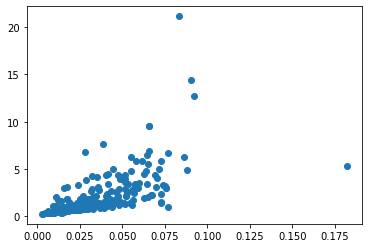

In [408]:
#plt.scatter(x=metric1_per_category, y=metric2_per_category)
plt.scatter(x=metric1_per_category, y=metric4)
(metric1_per_category).corr(metric4)

In [386]:
df.corrwith(metric4)

number_of_listings       0.180559
avg_listing_price_eur   -0.510061
revenue_from_push_ups    0.143431
dtype: float64

## Section1: C

In [88]:
df[REVENUE].sum()

887728.0

## Section2 B:experience

In [173]:
def add_dynamic_price_features(df):
    #k is a constant equals to the minimum allowed price
    #r proportional (or equals if k=0) to the push-up price percentage from AVG_ITEM_PRICE
    #r = p*AVG_ITEM_PRICE + k
    #R is the expected total revenue.
    
    outdf = pd.DataFrame(df)
    r = (pushup_price - k)/df[AVG_ITEM_PRICE]
    outdf["price_percentage"] = r
    items_count = df[ITEMS_COUNT].sum()
    currentR = df[REVENUE].sum()
    items_count = df[ITEMS_COUNT].sum()

    R_per_item = df[REVENUE]/df[ITEMS_COUNT]
    outdf["purchase_count/item"] = (df[REVENUE]/pushup_price)/df[ITEMS_COUNT]
    #outdf["revenue/item"] = df[REVENUE]/df[ITEMS_COUNT]

    #calculate R: the expected revenue
    #since the data is small, we use a foor loop instead of vectorizing
    R = np.zeros(df.shape[0])
    for i, (rr, Prob) in enumerate(zip(outdf["price_percentage"], outdf["purchase_count/item"])):
        X = df[AVG_ITEM_PRICE]
        #Prob = df["p/item"]
        items_count = df[ITEMS_COUNT]
        new_pushup_price = rr*X + k
        number_of_purchases = Prob*items_count
        R[i] = (new_pushup_price*number_of_purchases).sum()
        
    outdf["expected_total_revenue"] = R.tolist()
    return outdf

In [174]:
### THIRD ATTEMPT at B2 ###
#ignoring categories and focusing on calculating the relation between revenu and  avg_price
#the following help make small samples for each price

dfn = df.iloc[:,2:]
max_p= dfn[AVG_ITEM_PRICE].max()
cut = pd.cut(x=dfn[AVG_ITEM_PRICE], bins=np.arange(0.0, max_p, 1.0))
dfn = dfn.groupby(cut).agg({ITEMS_COUNT:"sum", AVG_ITEM_PRICE:"mean", REVENUE:"sum"})
dfn = dfn[dfn.notnull().all(axis=1)]

dfn = add_dynamic_price_features(dfn)

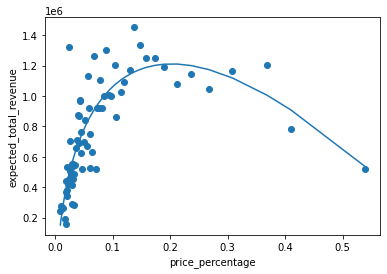

In [175]:
func = scatter_fit([dfn["price_percentage"], dfn["expected_total_revenue"]])

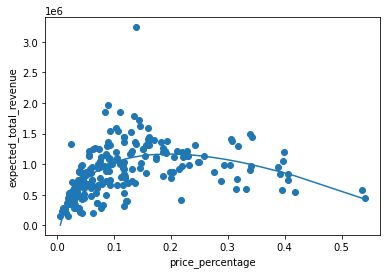

<function __main__.scatter_fit.<locals>.<lambda>(x)>

In [412]:
dfn2 = add_dynamic_price_features(df)
scatter_fit([dfn2["price_percentage"], dfn2["expected_total_revenue"]])

In [172]:
print("The max is approximately around 0.2 percentage.")
print("current totatl revenue: ", dfn[REVENUE].sum(), " Euro")
print("------")
print("nearest neighbours to 0.2 percentage:")
dfn.iloc[(dfn["price_percentage"]-0.2).abs().argsort()[:2]][["price_percentage", "expected_total_revenue"]]

The max is approximately around 0.2 percentage.
current totatl revenue:  887442.0  Euro
------
nearest neighbours to 0.2 percentage:


,price_percentage,expected_total_revenue
avg_listing_price_eur,,
"(10.0, 11.0]",0.189171,1.188695e+06
"(9.0, 10.0]",0.212333,1.079392e+06


In [411]:
print("Function approximation of percentage mapped to expected_revenue at 0.2:")
print(func(0.2), " Euro")

Function approximation of percentage mapped to expected_revenue at 0.2:
1210758.7755731465  Euro


The graph shows that around a 0.2 price percentage of the "average pushup item price", we achieve a maximum expected revenue. More than that we start losing. To find the expected revenue, we either take the nearest neighbor of the maximum, or use our function approximation our data $f(x)$ such that $f(x) = $ expected total revenue at $x$.

So according to the fit the expected revenue is around 1200000 Euro, while the one nearest neoubour expected revenue is between one million and 120000 million Euro.



### Section2: A

In [179]:
#A simple method to approximate price chane
#new_price = 4
#percentage_factor = new_price/pushup_price 

#dfn = add_dynamic_price_features(df)
#df["price_percentage"]*percentage_factor

#With the new percentages we approximate a mapping from "price_percentage" to the feature "purchase_count_per_item"
#with that we can generate a new "revenue" based on the new price thus calculating an approximate expected total price

#dfn.iloc[(dfn["price_percentage"]-0.2).abs().argsort()[:2]][["price_percentage", "expected_total_revenue"]]

## Section 3

In [432]:
df.sort_values([ITEMS_COUNT, AVG_ITEM_PRICE],ascending=False)#/df[ITEMS_COUNT].sum()

,category_2,category_3,number_of_listings,avg_listing_price_eur,revenue_from_push_ups,price_percentage,purchase_count/item,revenue/item,expected_total_revenue
235,WOMENS,TOPS_T_SHIRTS,1844512,10.469959,76166.0,0.191023,0.020647,0.041293,1.186904e+06
222,WOMENS,DRESSES,860056,39.783769,79424.0,0.050272,0.046174,0.092347,6.985539e+05
228,WOMENS,PULLOVERS_SWEATERS,713152,14.512787,47128.0,0.137810,0.033042,0.066084,1.370336e+06
227,WOMENS,OUTERWEAR,377058,46.638132,57032.0,0.042883,0.075628,0.151255,9.760007e+05
3,ACCESSORIES_JEWELLERY,JEWELRY,343493,17.935880,20554.0,0.111508,0.029919,0.059838,1.004007e+06
...,...,...,...,...,...,...,...,...,...
99,FOOTWEAR,TRADITIONAL_WOMEN_SHOES,72,24.555556,2.0,0.081448,0.013889,0.027778,3.404306e+05
160,MEN_OUTERWEAR,MEN_OUT_CAPES,65,45.791538,2.0,0.043676,0.015385,0.030769,2.022145e+05
156,MEN_FOOTWEAR,MEN_FOO_WELLINGTON_BOOTS,63,68.413333,6.0,0.029234,0.047619,0.095238,4.189390e+05
168,MEN_SHOES_NEW,MEN_FORMAL,33,82.545455,12.0,0.024229,0.181818,0.363636,1.325730e+06


In [441]:
df[df["category_3"]=="DRESSES"][ITEMS_COUNT]/df[ITEMS_COUNT].sum()

222    0.062196
Name: number_of_listings, dtype: float64

In [436]:
df[AVG_ITEM_PRICE].mean()

34.173101267443684